In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target+Count Encoding: Vary threshold
No blending of hierarchy, just check encoding NAICS using the target+counts

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_count_encoder import TargetCountEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [ ]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Comparison metrics

In [16]:
metrics_base = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

## Function to get metrics

In [9]:
def get_metrics(data, lambda_k = 100, enc_features = ['NAICS', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetCountEncoder(lambda_k = lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [10]:
count_sets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [11]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c, ['NAICS'])
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [12]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.665222,0.418726,0.305869,0.663565,0.346404,0.728748,1.0,5
1,test,0.667943,0.419437,0.307374,0.660096,0.346362,0.728667,1.0,10
1,test,0.666067,0.418503,0.306117,0.661281,0.346367,0.728632,1.0,20
1,test,0.642056,0.421045,0.298155,0.716268,0.345852,0.728860,1.0,50
1,test,0.640764,0.420426,0.297404,0.717029,0.345941,0.728822,1.0,100
1,test,0.617398,0.418766,0.289226,0.758481,0.346532,0.728086,1.0,200
1,test,0.681993,0.416693,0.312511,0.625074,0.347546,0.728882,1.0,500
1,test,0.660026,0.419070,0.303897,0.674816,0.346619,0.729057,1.0,1000
1,test,0.660671,0.419319,0.304280,0.674224,0.347198,0.729125,1.0,2000


In [13]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.660232,0.449411,0.337053,0.674140,0.383228,0.728352,0.0,5
0,test,0.659772,0.449744,0.336973,0.675961,0.383781,0.728355,0.0,10
0,test,0.660361,0.449352,0.337090,0.673724,0.384057,0.728652,0.0,20
0,test,0.659911,0.449521,0.336942,0.675077,0.382419,0.728333,0.0,50
0,test,0.659847,0.450388,0.337295,0.677574,0.383074,0.728524,0.0,100
0,test,0.661602,0.449109,0.337602,0.670603,0.383441,0.728287,0.0,200
0,test,0.657193,0.448977,0.335372,0.678978,0.380362,0.727127,0.0,500
0,test,0.623337,0.446377,0.319905,0.738230,0.374350,0.722996,0.0,1000
0,test,0.617484,0.443801,0.316589,0.741924,0.368551,0.720260,0.0,2000


In [14]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A02_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A02_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

#### Regular randomized test

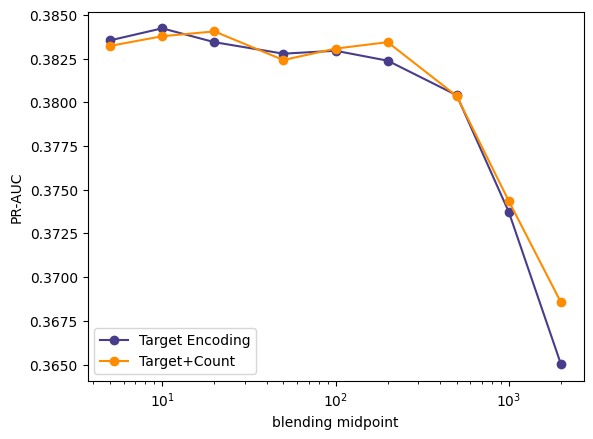

In [30]:
fig, ax = plt.subplots()
metrics_base[metrics_base['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target Encoding',color='darkslateblue', style='o-')
metrics_df[metrics_df['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='o-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending midpoint')
fig.savefig(Path(setup.temp_path).joinpath('A02_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

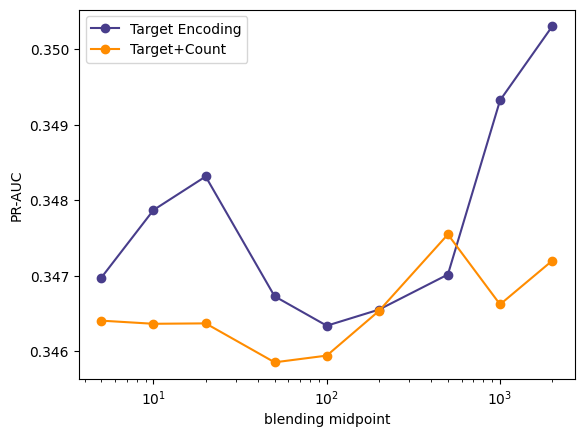

In [31]:
fig, ax = plt.subplots()
metrics_base[metrics_base['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target Encoding',color='darkslateblue', style='o-')
metrics_df[metrics_df['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='o-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending midpoint')
fig.savefig(Path(setup.temp_path).joinpath('A02_PLOT_compare_base_ho.png'),
            bbox_inches='tight')